training set (60000, 28, 28)
test set (10000, 28, 28)


2022-01-04 21:20:45.113265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 21:20:45.118327: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 21:20:45.118731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 21:20:45.119395: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 784)               0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 784)              0         
 se)                                                             
                                                                 
 dense_block0 (Dense)        (None, 1024)              803840    
                                                                 
 bach_normalization_block0 (  (None, 1024)             4096      
 BatchNormalization)                                             
                                                                 
 gaussian_noise_block0 (Gaus  (None, 1024)             0         
 sianNoise)                                                      
                                                        

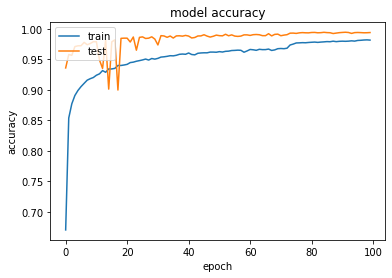

'Ejecución consola\n\nEpoch 1/100\n600/600 [==============================] - 15s 22ms/step - loss: 1.1919 - accuracy: 0.6427 - val_loss: 0.2582 - val_accuracy: 0.9230 - lr: 0.1000\nEpoch 2/100\n600/600 [==============================] - 14s 23ms/step - loss: 0.4901 - accuracy: 0.8518 - val_loss: 0.2221 - val_accuracy: 0.9478 - lr: 0.1000\nEpoch 3/100\n600/600 [==============================] - 14s 23ms/step - loss: 0.4132 - accuracy: 0.8780 - val_loss: 0.3221 - val_accuracy: 0.9016 - lr: 0.1000\nEpoch 4/100\n600/600 [==============================] - 14s 23ms/step - loss: 0.3655 - accuracy: 0.8910 - val_loss: 0.0993 - val_accuracy: 0.9717 - lr: 0.1000\nEpoch 5/100\n600/600 [==============================] - 14s 23ms/step - loss: 0.3465 - accuracy: 0.8984 - val_loss: 0.1308 - val_accuracy: 0.9624 - lr: 0.1000\nEpoch 6/100\n600/600 [==============================] - 14s 23ms/step - loss: 0.3221 - accuracy: 0.9059 - val_loss: 0.0968 - val_accuracy: 0.9736 - lr: 0.1000\nEpoch 7/100\n600/6

In [1]:
# -*- coding: utf-8 -*-
"""RNA-MNIST.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1xsGYJ98ShBFwrAi8nZ4ck8xTQhnaFcJR
"""

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Reshape, Dropout
from tensorflow.keras.layers import BatchNormalization as BN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GaussianNoise as GN
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras

import matplotlib.pyplot as plt


def add_layers(model: keras.models.Model, block: int):
    model.add(Dense(1024, name=f"dense_block{block}"))
    model.add(BN(name=f"bach_normalization_block{block}"))
    model.add(GN(0.3, name=f"gaussian_noise_block{block}"))
    model.add(Activation('relu', name=f"relu_block{block}"))


batch_size = 100
epochs = 100
num_classes = 10
blocks = 5

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('training set', x_train.shape)
print('test set', x_test.shape)

x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize [0..255]-->[0..1]
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

# Data Augmentation with an ImageGenerator
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=10
)

# Model, note the reshape
model = Sequential()
model.add(Reshape(target_shape=(784,), input_shape=(28, 28, 1)))
model.add(GN(0.3))

for i in range(blocks):
    add_layers(model, i)

model.add(Dense(num_classes, activation='softmax'))

model.summary()

sgd = Adam(learning_rate=0.1)
set_lr = ReduceLROnPlateau( monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)

model.compile(
    loss='categorical_crossentropy',
    optimizer=sgd,
    metrics=['accuracy']
)

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(x_train) / batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[set_lr],
    verbose=1
)

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()